
# Table of Contents
1. [Initialize Imports & Load Data](#loaddata)
2. [Create Augmentations](#createaugmentations)
    2.1 [Analyze Augmentations](#analyzeaugmentations)
3. [Set new Baseline w/ Augmentations (same architecture)](#setnewsame)
4. [Interpret new approach](#interpretnew)
5. [Compare w/ Baseline](#comparewithbaseline)
6. [Adjust Architecture w/ Augmentations](#adjustwithaugmentations)
7. [Compare w/ Baseline + Augmentations](#comparewithbaselineplusaugmentations)
8. [Conclusions](#conclusions)

# Initialize Imports & Load Data<a name="loaddata"></a>

In [1]:
import numpy as np
import pandas as pd
import glob
from os import makedirs, path
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import visualkeras
import pickle

# Clear our Tensor Graph
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)

In [2]:
constraints = pickle.load(open('./pickles/constraints.p', 'rb'))
constraints
constraints['BATCH_SIZE'] = 256

In [3]:
# Load our pickles :pickle:
train_df = pd.read_pickle('./pickles/train_df.pkl')
val_df = pd.read_pickle('./pickles/val_df.pkl')

# Get whole shape to define fitting params for our baseline ConvNet
total_train = train_df.shape[0]
total_validate = val_df.shape[0]

<AxesSubplot:>

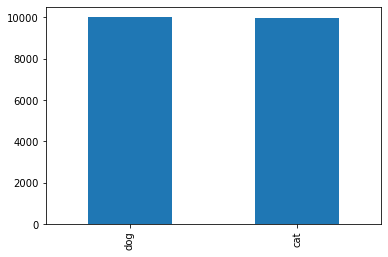

In [4]:
train_df['category'].value_counts().plot.bar()

<AxesSubplot:>

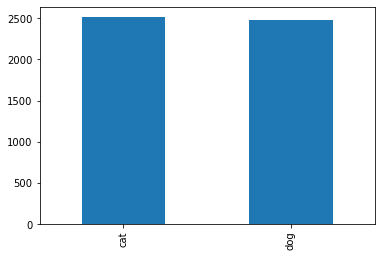

In [5]:
val_df['category'].value_counts().plot.bar()

# Create Augmentations<a name="createaugmentations"></a>

In [6]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./constraints['IMG_COL_CHANNEL'],
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

val_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./constraints['IMG_COL_CHANNEL'],
)

In [7]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='category',
    target_size=constraints['IMAGE_SIZE'],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    seed=42,
)

val_data = val_gen.flow_from_dataframe(
    val_df,
    x_col='Filepath',
    y_col='category',
    target_size=constraints['IMAGE_SIZE'],
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    seed=42
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


our datagens will create 15 augments per image

## Analyze Augmentations<a name="analyzeaugmentations"></a>

In [8]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_gen.flow_from_dataframe(
    example_df, 
    x_col='Filepath',
    y_col='category',
    target_size=constraints['IMAGE_SIZE'],
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


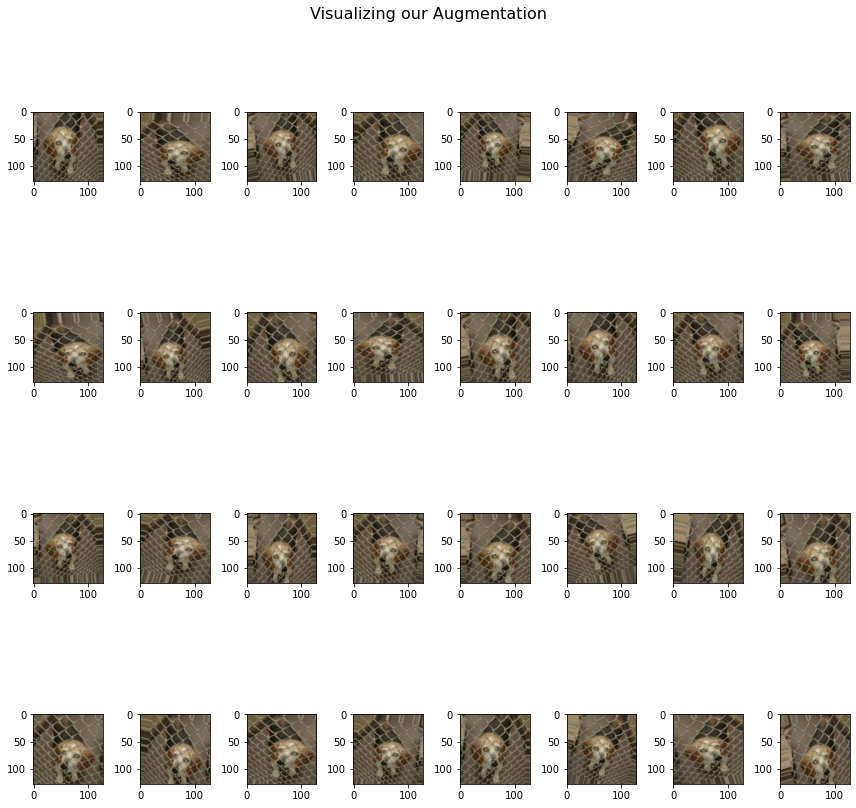

In [9]:
#Visualizing our Augmentation

plt.figure(figsize=(12, 12))
for i in range(0, 32):
    plt.subplot(4, 8, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.suptitle('Visualizing our Augmentation', fontsize=16, y=1.01)
plt.show()

# Set new Baseline w/ Augmentations (same architecture)<a name="setnewsame"></a>

In [10]:
tf.keras.backend.clear_session()

In [11]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    
    x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    
    x = tf.keras.layers.Flatten()(x)
        
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(2, activation='softmax', name='softmax')(x)
    
    
    return tf.keras.Model(inputs, outputs)

model = build_model(input_shape=constraints['IMAGE_SIZE'] + (3,))

2023-03-21 01:05:27.251879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 01:05:27.276071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 01:05:27.276255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 01:05:27.277433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 01:05:27.277581: I tensorflow/compiler/xla/stream_executo

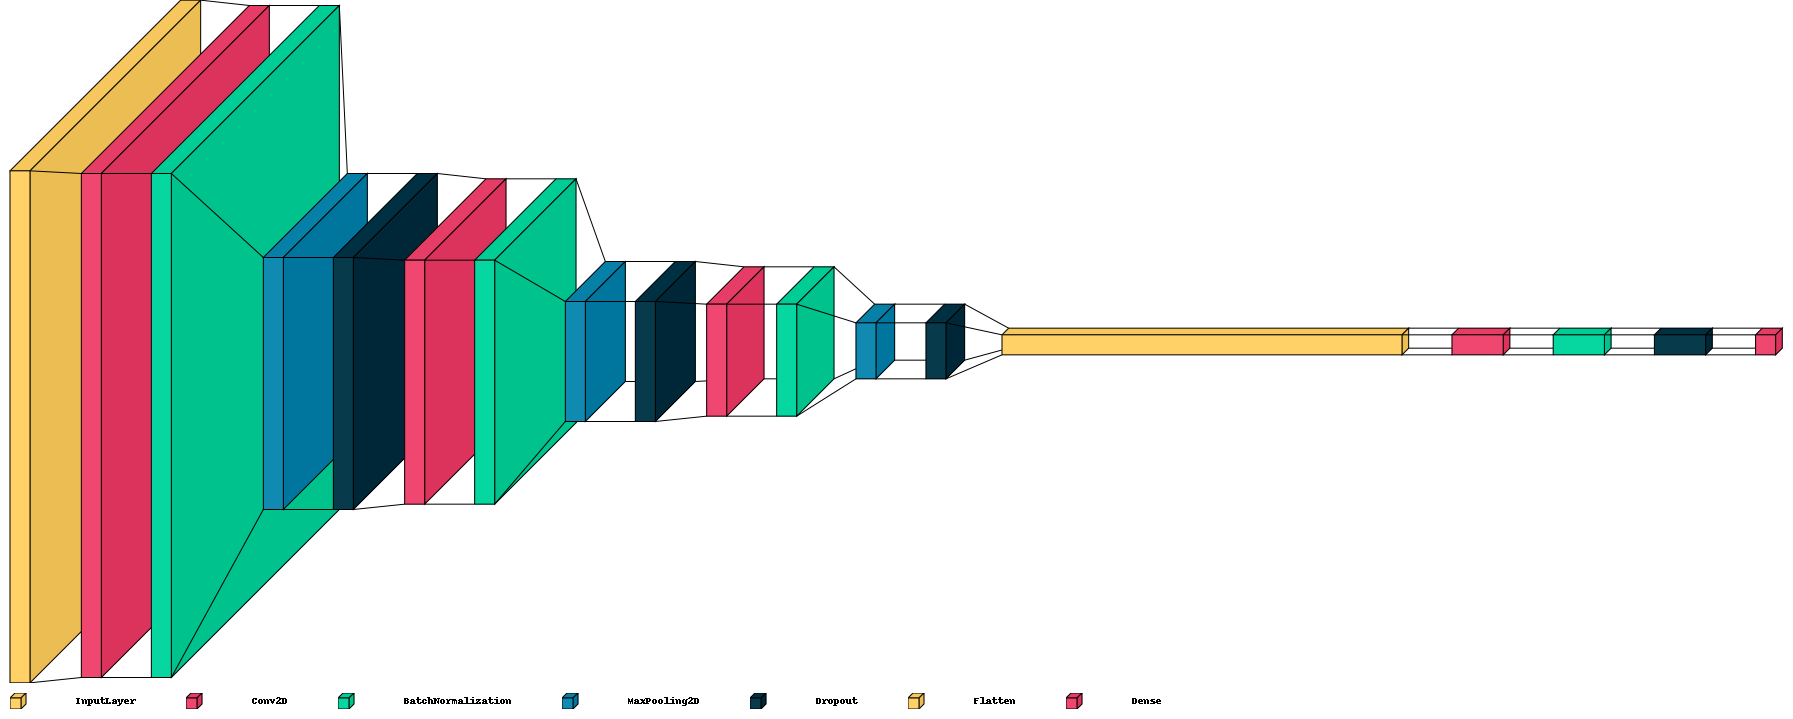

In [12]:
visualkeras.layered_view(model, legend=True, spacing=50, )

In [13]:
# If no improvement in 10 epochs stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)


# Learning Rate Modulation
lr_mod = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=5, min_lr=0.00001)
# Set Call Backs
callbacks = [early_stop, lr_mod]

In [14]:
# Compile the model
model.compile(optimizer='rmsprop', 
             loss='categorical_crossentropy', 
             metrics=['accuracy']
            )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496 

In [15]:
# Fit the New Modclear_sessionmeit

epochs = 5 if constraints['FAST_RUN'] else 100
hist = model.fit(train_data,
                 epochs=epochs,
                 batch_size=constraints['BATCH_SIZE'],
                validation_data=val_data,
                validation_steps=total_validate//constraints['BATCH_SIZE'],
                steps_per_epoch=total_train//constraints['BATCH_SIZE'],
                 callbacks=callbacks)

Epoch 1/100


2023-03-21 01:05:28.854683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-21 01:05:29.053418: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55d0a46b4970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-21 01:05:29.053452: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2023-03-21 01:05:29.059747: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-21 01:05:29.826323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-03-21 01:05:30.622782: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Comp

78/78 [==============================] - 13s 103ms/step - loss: 1.2204 - accuracy: 0.5573 - val_loss: 2.1565 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - 8s 99ms/step - loss: 0.9286 - accuracy: 0.5958 - val_loss: 1.8608 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - 8s 98ms/step - loss: 0.8069 - accuracy: 0.6118 - val_loss: 1.6583 - val_accuracy: 0.4951 - lr: 0.0010
Epoch 4/100
78/78 [==============================] - 8s 99ms/step - loss: 0.7037 - accuracy: 0.6318 - val_loss: 0.6707 - val_accuracy: 0.5872 - lr: 0.0010
Epoch 5/100
78/78 [==============================] - 8s 100ms/step - loss: 0.6389 - accuracy: 0.6607 - val_loss: 0.8264 - val_accuracy: 0.5016 - lr: 0.0010
Epoch 6/100
78/78 [==============================] - 8s 107ms/step - loss: 0.6178 - accuracy: 0.6827 - val_loss: 0.6458 - val_accuracy: 0.6102 - lr: 0.0010
Epoch 7/100
78/78 [==============================] - 8s 103ms/step - loss: 0.6

In [16]:
model.save_weights("./weights/augments_baseline_model.h5")

# Interpret new approach<a name="interpretnew"></a>

In [17]:
def interpret_epoch_hist(history): # Credit Hamza Manssor
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    ax1.plot(history.history['loss'], color='b', label="Training loss")
    ax1.plot(history.history['val_loss'], color='r', label="validation loss")
    ax1.set_xticks(np.arange(1, epochs, 1))
    ax1.set_yticks(np.arange(0, 1, 0.1))
    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    ax2.set_xticks(np.arange(1, epochs, 1))

    legend = plt.legend(loc='best', shadow=True)
    plt.tight_layout()
    plt.show()

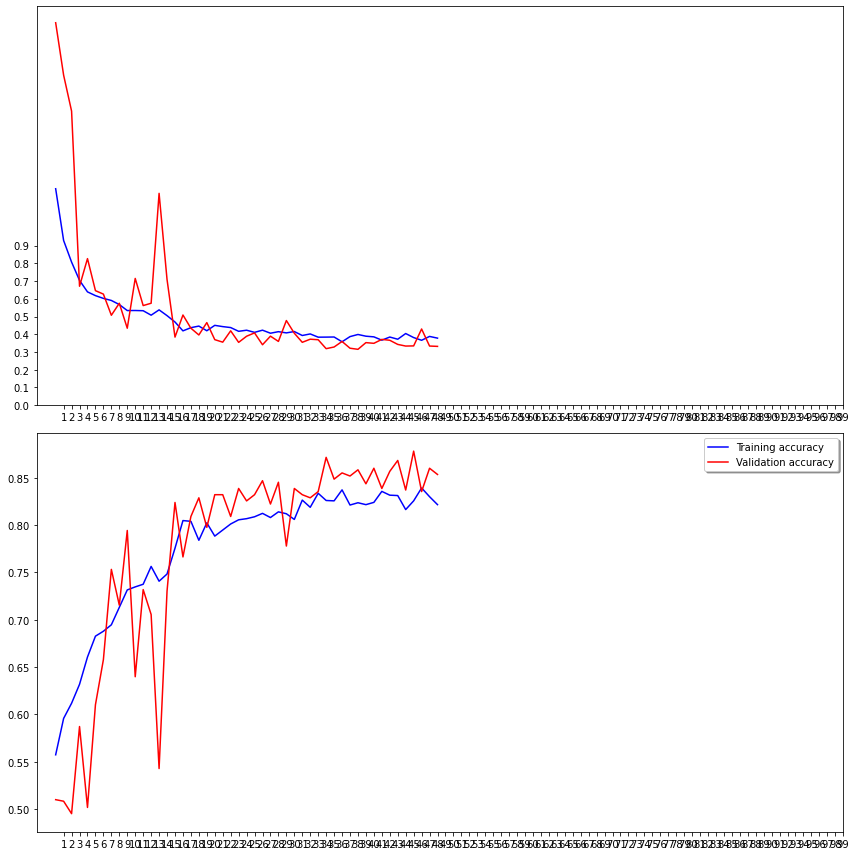

In [18]:
interpret_epoch_hist(hist)

In [19]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)

In [20]:
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)    
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    
    x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    
    x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    
    x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Flatten()(x)
        
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(2, activation='softmax', name='softmax')(x)
    
    
    return tf.keras.Model(inputs, outputs)


model = build_model(input_shape=constraints['IMAGE_SIZE'] + (3,))

In [21]:
callbacks = [early_stop, lr_mod]
model.compile(optimizer='adam', 
             loss='categorical_crossentropy', 
             metrics=['accuracy']
            )
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496 

In [22]:
# Fit the New Model
%timeit

epochs = 5 if constraints['FAST_RUN'] else 50
hist = model.fit(train_data,
                 epochs=epochs,
                validation_data=val_data,
                validation_steps=total_validate//constraints['BATCH_SIZE'],
                steps_per_epoch=total_train//constraints['BATCH_SIZE'],
                 callbacks=callbacks)

Epoch 1/50


2023-03-21 01:12:02.889875: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


78/78 [==============================] - 13s 110ms/step - loss: 1.1860 - accuracy: 0.5413 - val_loss: 1.7073 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 2/50
78/78 [==============================] - 8s 103ms/step - loss: 0.8511 - accuracy: 0.6038 - val_loss: 2.7911 - val_accuracy: 0.4753 - lr: 0.0010
Epoch 3/50
78/78 [==============================] - 8s 99ms/step - loss: 0.7574 - accuracy: 0.6178 - val_loss: 2.3855 - val_accuracy: 0.5033 - lr: 0.0010
Epoch 4/50
78/78 [==============================] - 8s 98ms/step - loss: 0.7214 - accuracy: 0.6350 - val_loss: 1.3885 - val_accuracy: 0.5214 - lr: 0.0010
Epoch 5/50
78/78 [==============================] - 8s 100ms/step - loss: 0.6838 - accuracy: 0.6358 - val_loss: 1.5182 - val_accuracy: 0.4868 - lr: 0.0010
Epoch 6/50
78/78 [==============================] - 8s 99ms/step - loss: 0.6440 - accuracy: 0.6526 - val_loss: 0.7709 - val_accuracy: 0.5822 - lr: 0.0010
Epoch 7/50
78/78 [==============================] - 8s 100ms/step - loss: 0.6402 - 

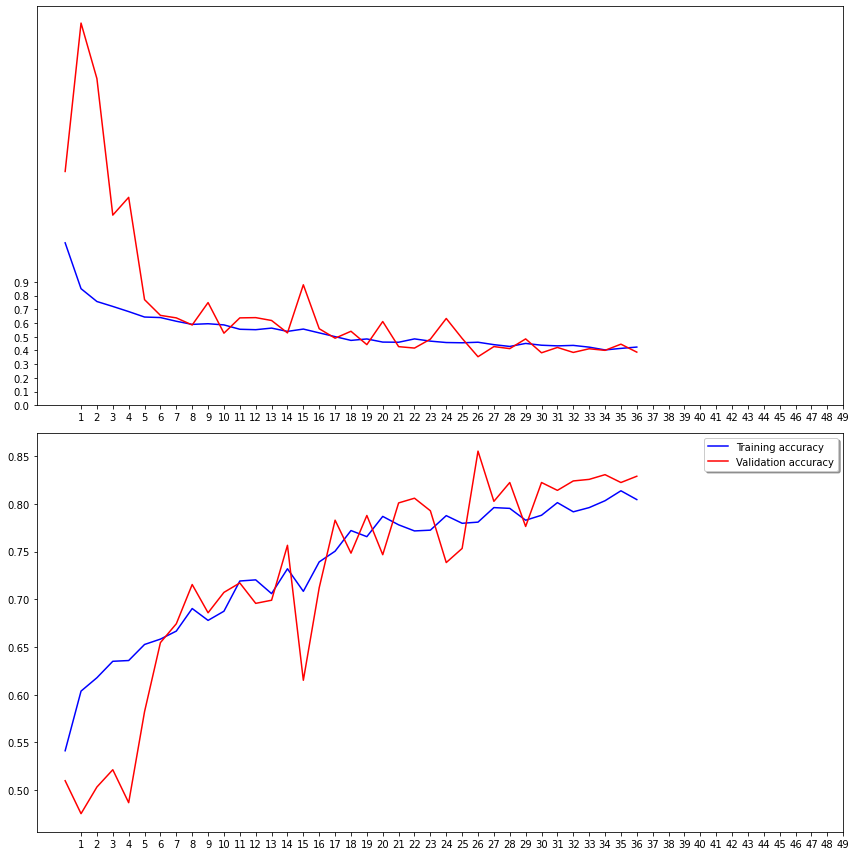

In [23]:
interpret_epoch_hist(hist)

In [24]:
model.save_weights("./weights/augments_vgg_model.h5")

# Compare w/ Baseline<a name="comparewithbaseline"></a>

# Adjust Architecture w/ Augmentations<a name="adjustwithaugmentations"></a>

# Compare w/ Baseline + Augmentations<a name="comparewithbaselineplusaugmentations"></a>

# Conclusions<a name="conclusions"></a>